<a href="https://colab.research.google.com/github/kirwarobert/cnn/blob/main/time_series_forecasting_with_prophet(kpsk_kib_21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [ ]:
pjme = pd.read_csv('/content/PJME_hourly.csv', index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

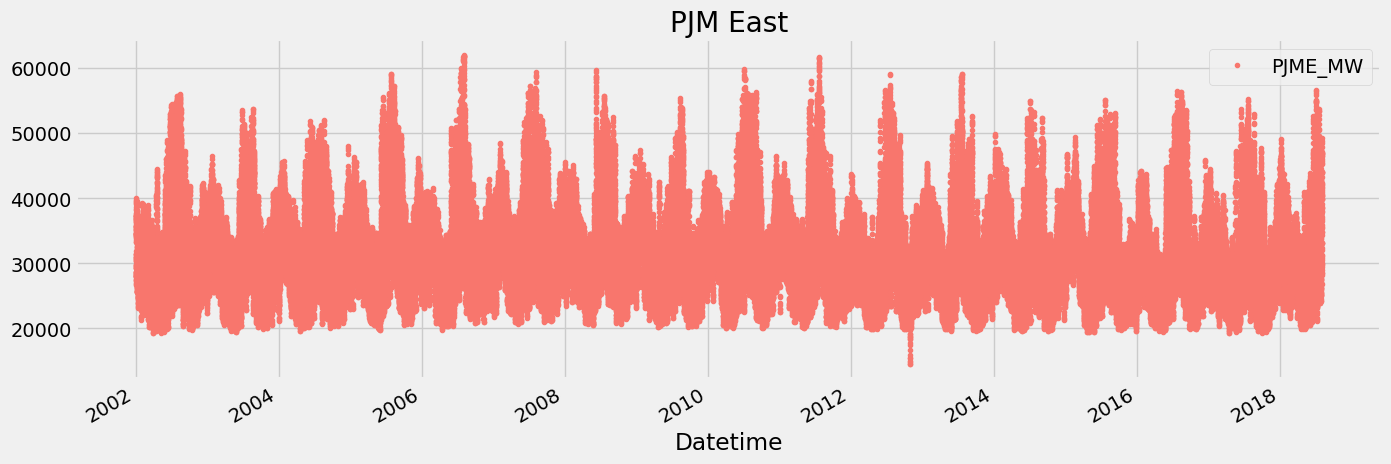

In [ ]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [ ]:
def create_features(df, label=None):
   # Creates time series features from datetime index.
   df = df.copy()
   df['date'] = df.index
   df['hour'] = df['date'].dt.hour
   df['dayofweek'] = df['date'].dt.dayofweek
   df['quarter'] =df['date'].dt.quarter
   df['month'] = df['date'].dt.month
   df['year'] =df['date'].dt.year
   df['dayofyear'] = df['date'].dt.dayofyear
   df['dayofmonth'] = df['date'].dt.day
   df['weekofyear'] = df['date'].dt.isocalendar().week

   x = df[['hour','dayofweek','quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
   if label:
     y = df[label]
     return x, y
   return X
x, y = create_features(pjme, label = 'PJME_MW')
features_and_target = pd.concat([x, y], axis=1)

In [ ]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

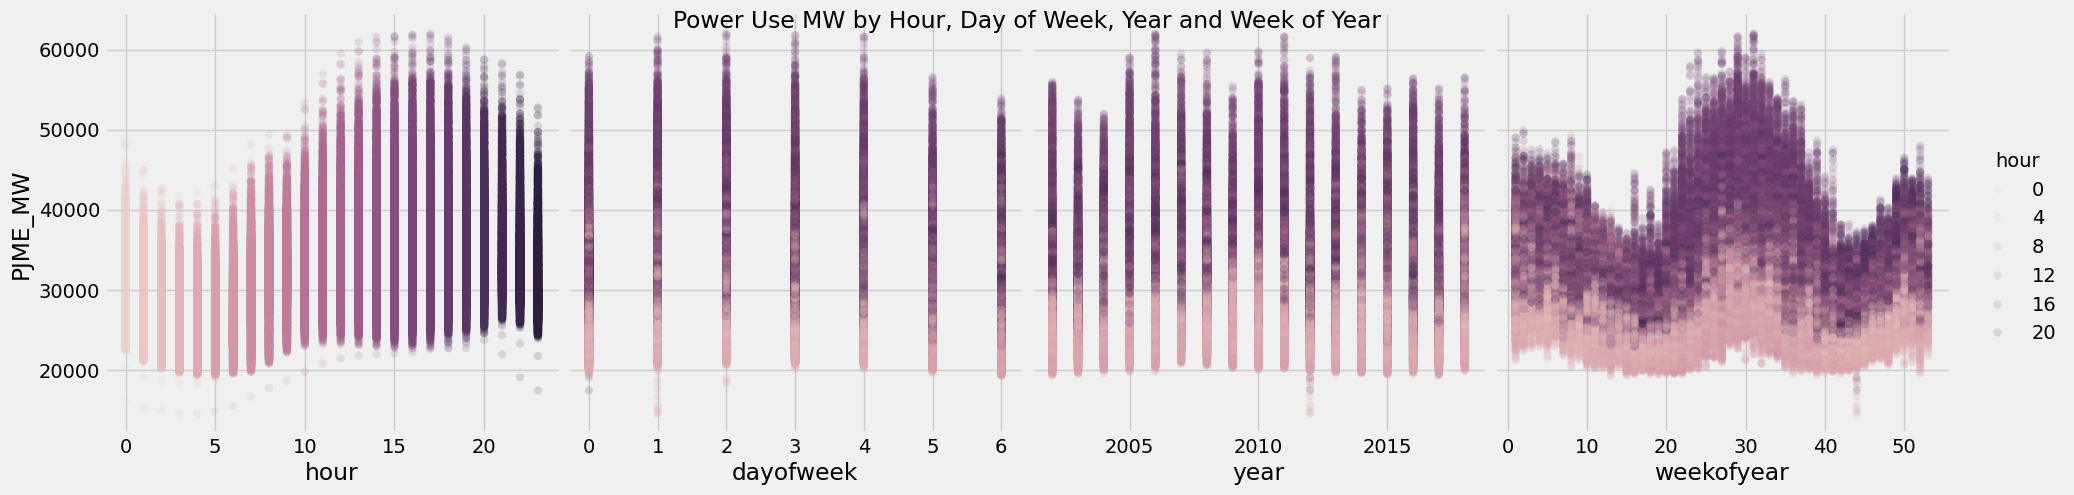

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split
Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [ ]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [ ]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJME East', style='.')
plt.show()

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [ ]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkh1ah9py/p9r4wany.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkh1ah9py/plmk8tb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=653', 'data', 'file=/tmp/tmpkh1ah9py/p9r4wany.json', 'init=/tmp/tmpkh1ah9py/plmk8tb5.json', 'output', 'file=/tmp/tmpkh1ah9py/prophet_modelu_nf7ej8/prophet_model-20250329062725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Format data for prophet model using ds and y
pjme_train = pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}) # Rename columns outside the fit method
#pjme_train.reset_index() \  <- Remove this line to avoid resetting the index twice.
#    .rename(columns={'Datetime':'ds',
#                     'PJME_MW':'y'}).head(

In [ ]:
pjme_test_fcst.head()

NameError: name 'pjme_test_fcst' is not defined

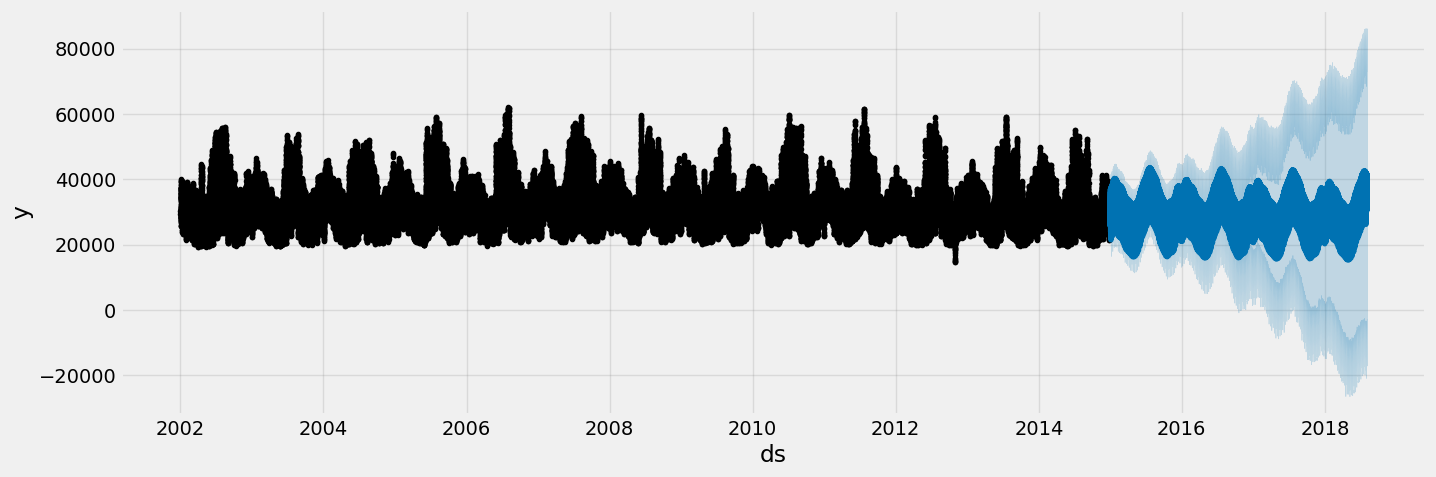

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

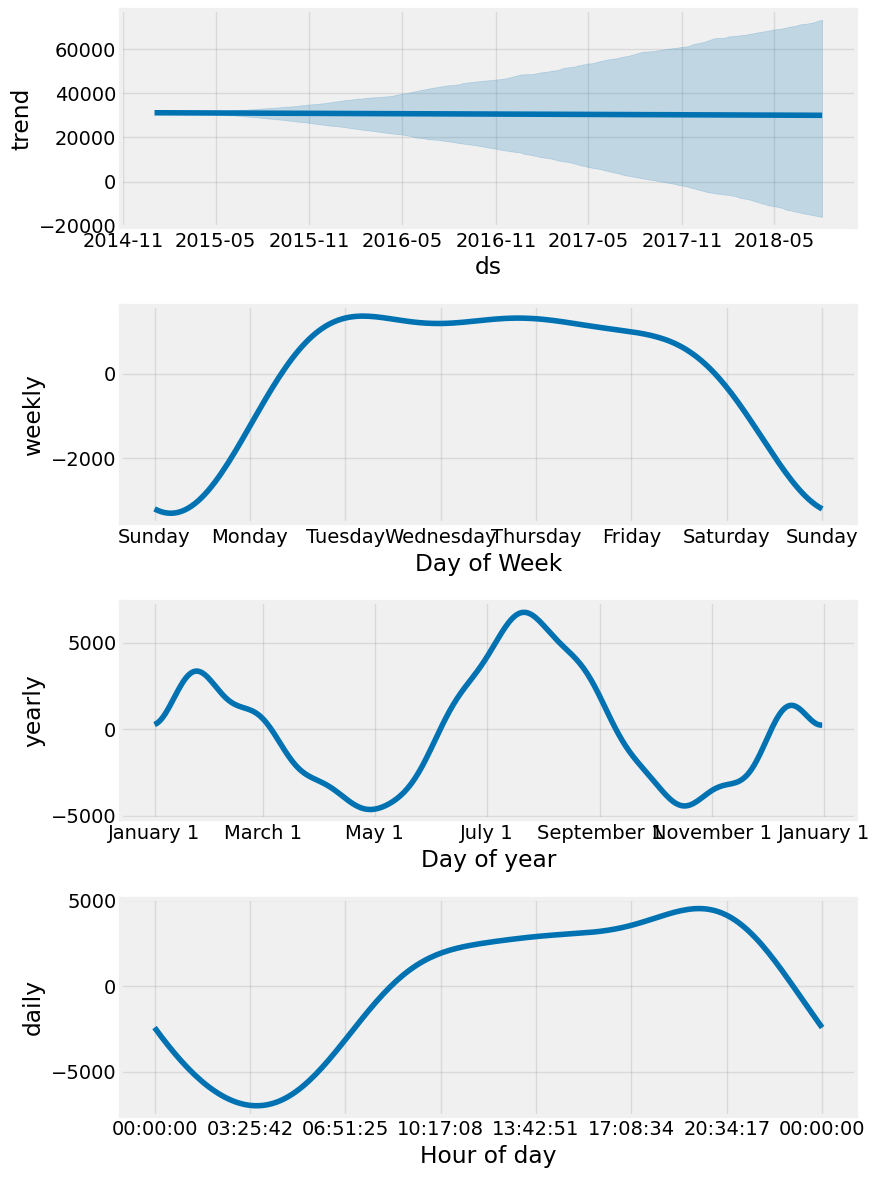

In [ ]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

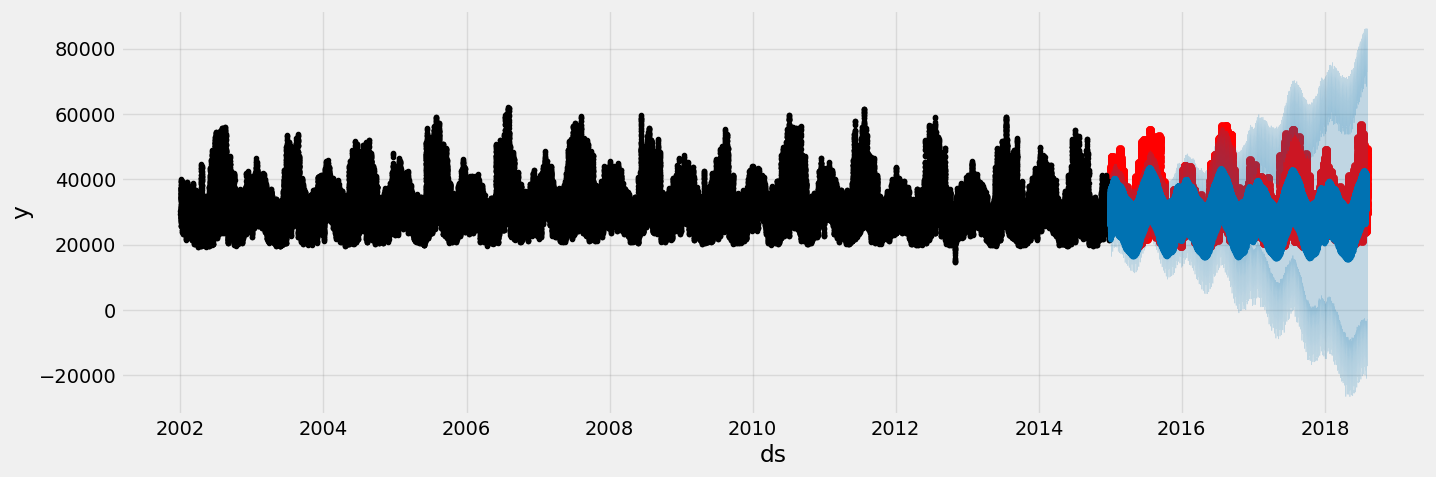

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Look at first month of predictions

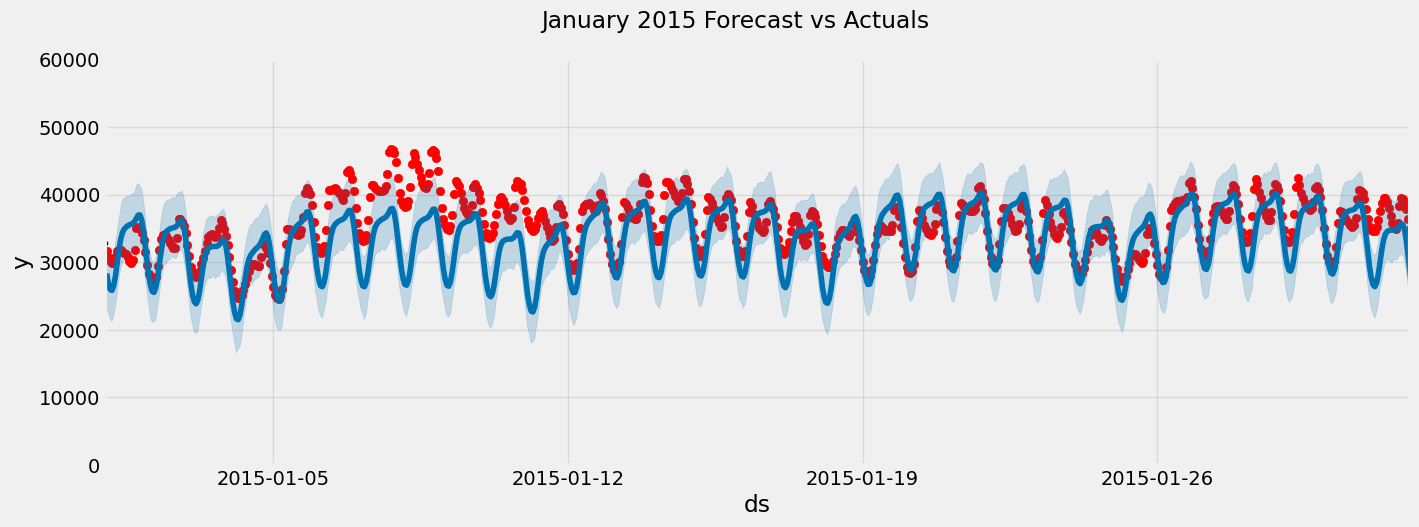

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower= pd.to_datetime('01-01-2015'),
              upper=pd.to_datetime('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# Single Week of Predictions

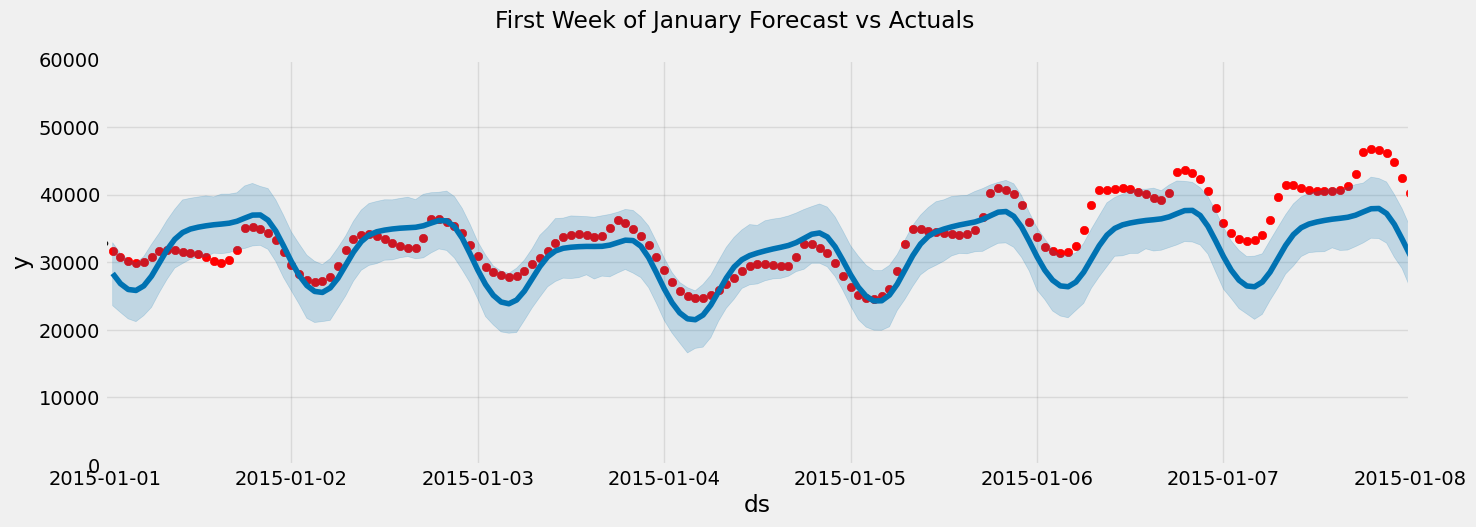

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'), upper=pd.to_datetime('01-08-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Error Metrics

Our RMSE error is 43761675  
Our MAE error is 5181.78  
Our MAPE error is 16.5%

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE):
[Check that out here](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-xgboost/)

In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

NameError: name 'pjme_test_fcst' is not defined

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.911537928106

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(16.512003880182647)

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [ ]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqiuh6o7h/2cwt2b7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqiuh6o7h/tfmcx_n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57107', 'data', 'file=/tmp/tmpqiuh6o7h/2cwt2b7z.json', 'init=/tmp/tmpqiuh6o7h/tfmcx_n6.json', 'output', 'file=/tmp/tmpqiuh6o7h/prophet_modelyoyxsil8/prophet_model-20250323145354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Predict With Holidays

In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Plot Holiday Effect

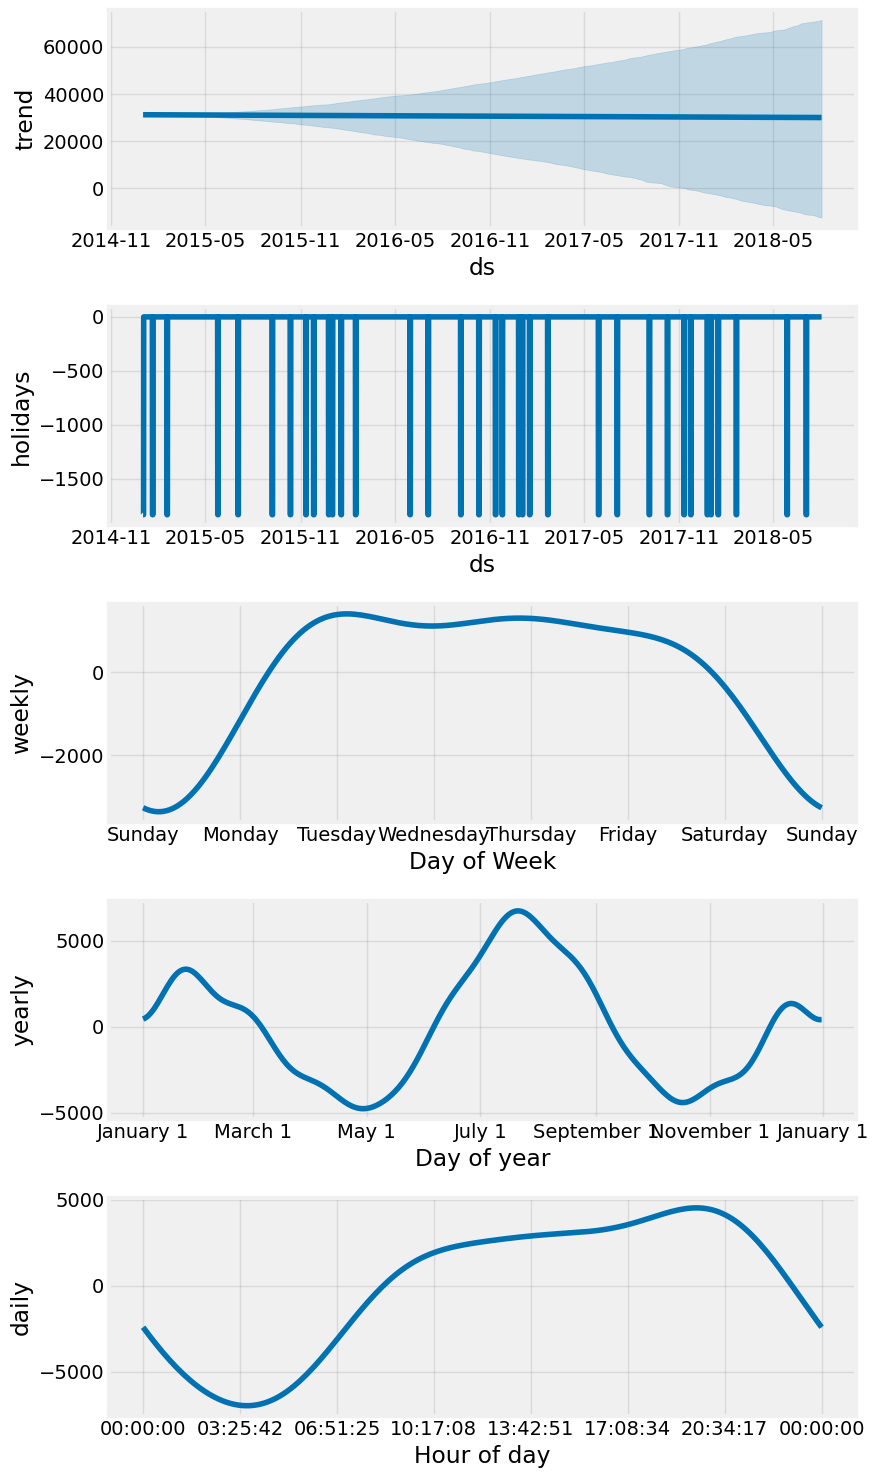

In [ ]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43957492.85018296

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5192.348054859118

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

np.float64(16.541420012252114)

# Compare Models Just for Holiday Dates
Lets plot Forecast model with and without holidays for 4th of July. It does look like the model with holidays is more accurate for this holiday.

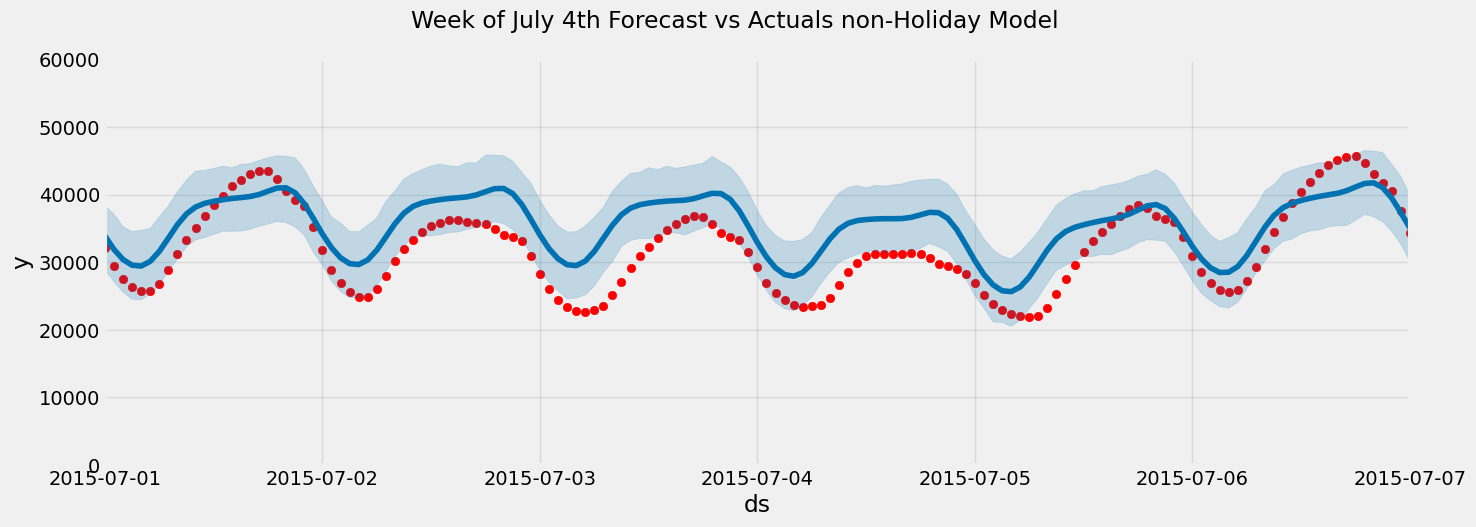

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('07-01-2015'), upper=pd.to_datetime('07-7-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

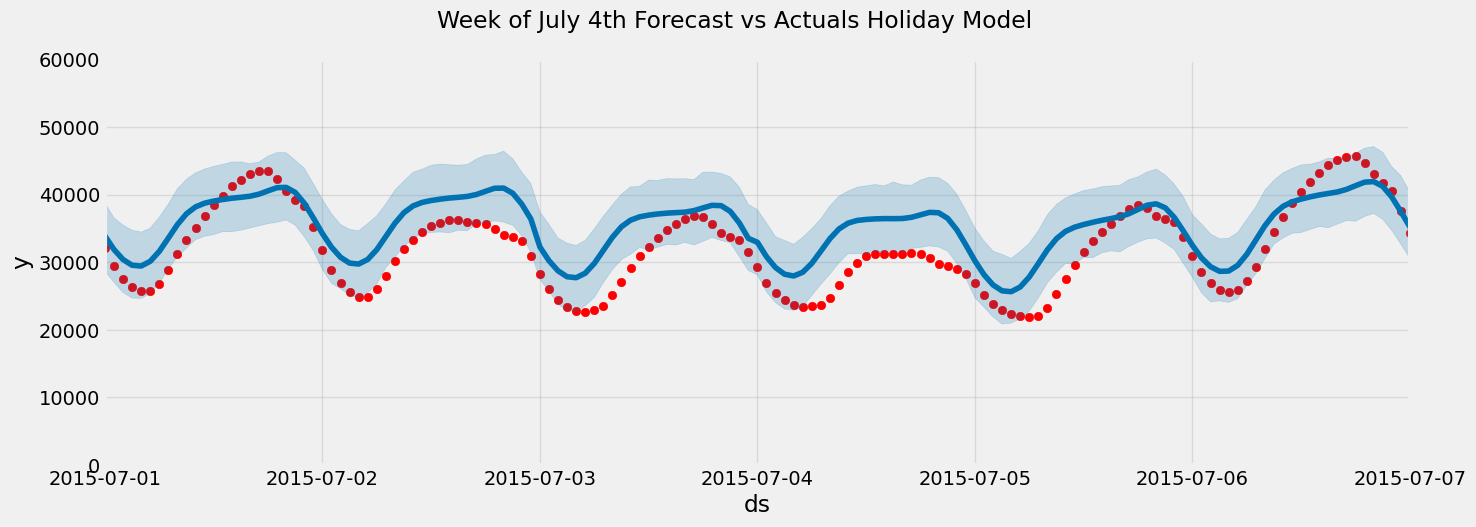

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower= pd.to_datetime('07-01-2015'), upper= pd.to_datetime('07-7-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

## Compare Error for just 4th of July
The error has gone down for this date.

In [ ]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [ ]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2156.3999535993557

In [ ]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2149.495833083406

# Error of all Holidays
- Holiday error has gone up! This is unexpected.

In [ ]:
holiday_list = holiday_df['ds'].tolist()

In [ ]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [ ]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5217.612940729632

In [ ]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5115.2409876098545

# Identify Error by holiday
- We can see different holidays respond differently in this model. The model would perform better if we specifically identify holidays instead of lumping them all together as "USFederalHolidays"

In [ ]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3077.5 
 MAE (Holiday Model): 2671.1 
 Diff 406.5
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2400.6 
 MAE (Holiday Model): 2088.2 
 Diff 312.4
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11149.8 
 MAE (Holiday Model): 12793.5 
 Diff -1643.8
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1564.9 
 MAE (Holiday Model): 1626.1 
 Diff -61.2
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6078.9 
 MAE (Holiday Model): 4295.6 
 Diff 1783.3
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.9 
 MAE (Holiday Model): 4321.7 
 Diff -469.8
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1592.0 
 MAE (Holiday Model): 1883.0 
 Diff -291.0
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2046.7 
 MAE (Holiday Model): 1586.2 
 Diff 460.5
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4660.0 
 MAE (Holiday Model): 3777.5 
 Diff 882.5
Holiday: December 25, 2015:    


# Plot Error of Each Forecast
- We can see that both of our models generalize well, but struggle with peak demand days.
- Seems to be under forecasting many days.

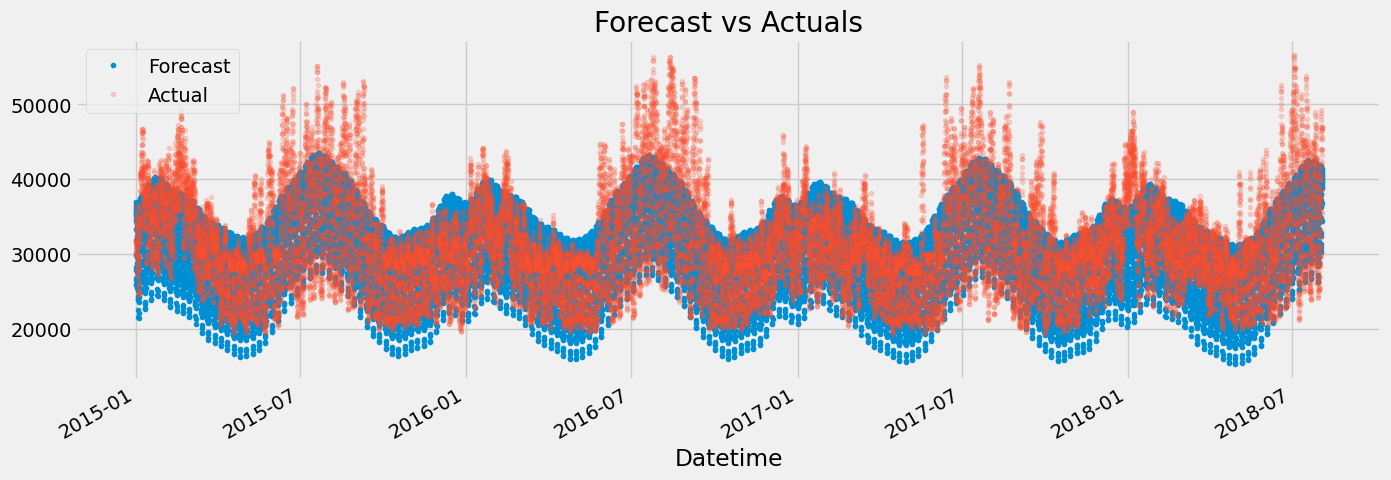

In [ ]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

# Data Cleaning
- Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.
- We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.

This plot shows the bad data highlighted in red.

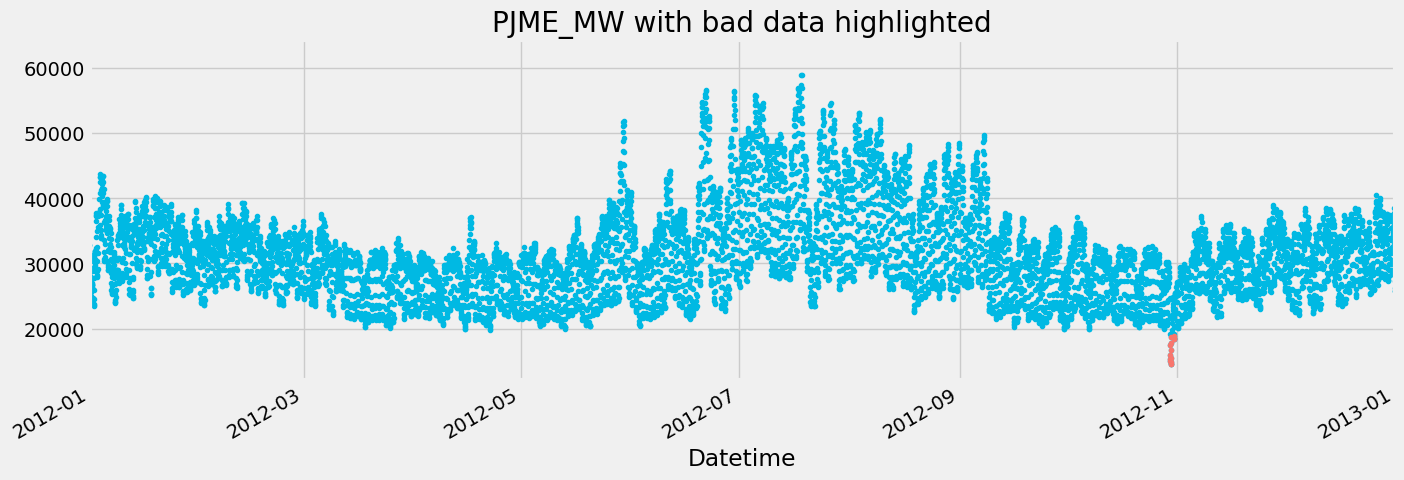

In [ ]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

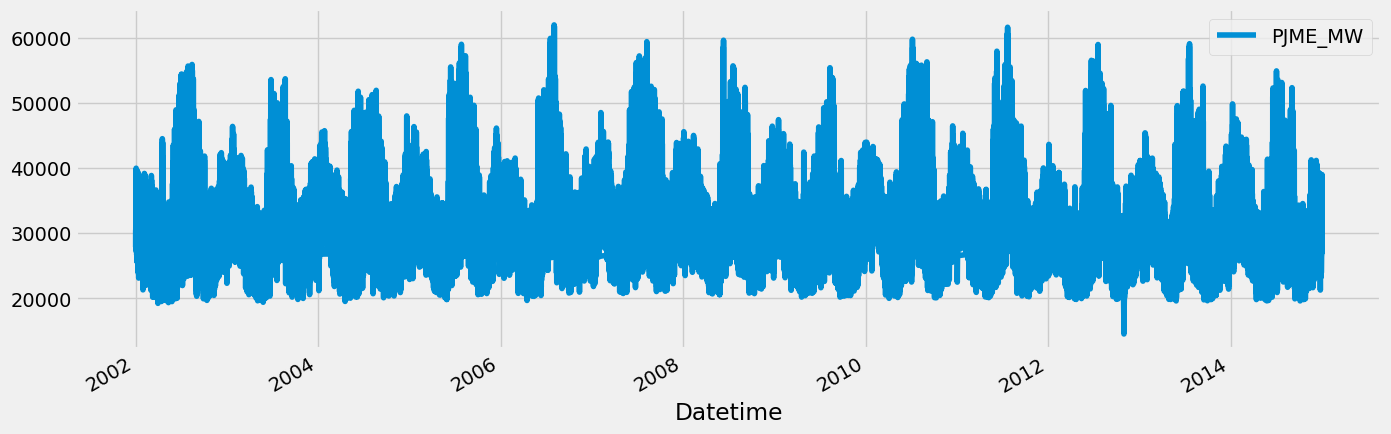

In [ ]:
pjme_train.plot(figsize=(15, 5))
plt.show()

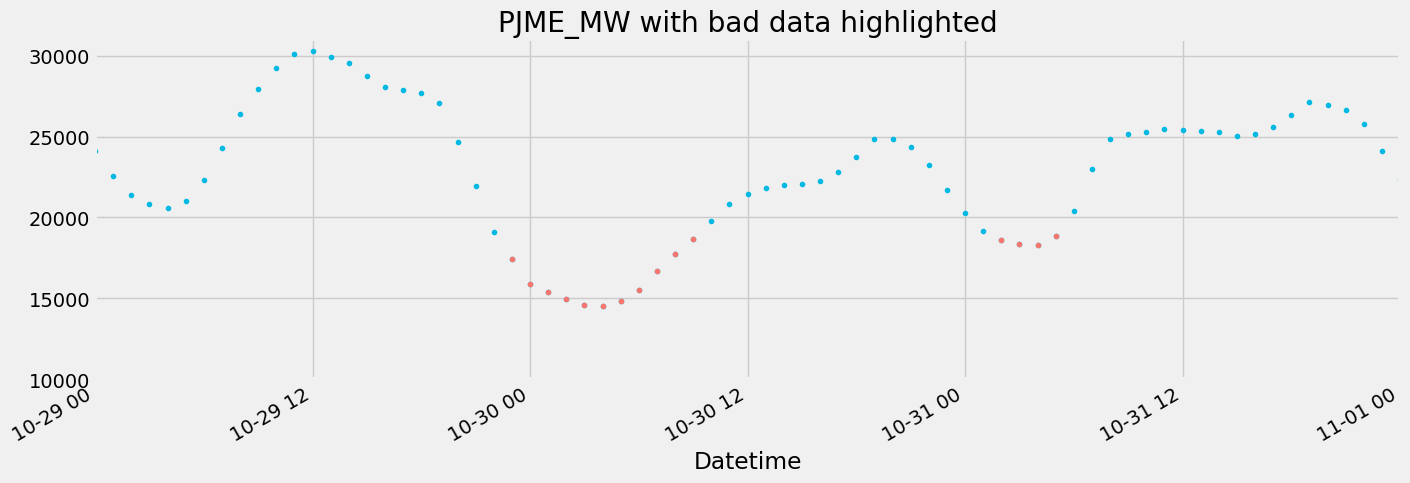

In [ ]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [ ]:
# Clean Data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Train model on clean data
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Predict on training set with clean model
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqiuh6o7h/54i5g2n0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqiuh6o7h/y1tdh9mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63142', 'data', 'file=/tmp/tmpqiuh6o7h/54i5g2n0.json', 'init=/tmp/tmpqiuh6o7h/y1tdh9mi.json', 'output', 'file=/tmp/tmpqiuh6o7h/prophet_model3u2nmnsk/prophet_model-20250323150321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:03:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


After cleaning we see a slight improvement in score compared to the first model. More data cleaning, along with holidays could yield even better results. Give it a try!

In [ ]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43776755.4019 - MAE 5182.9728 - MAPE 16.5045


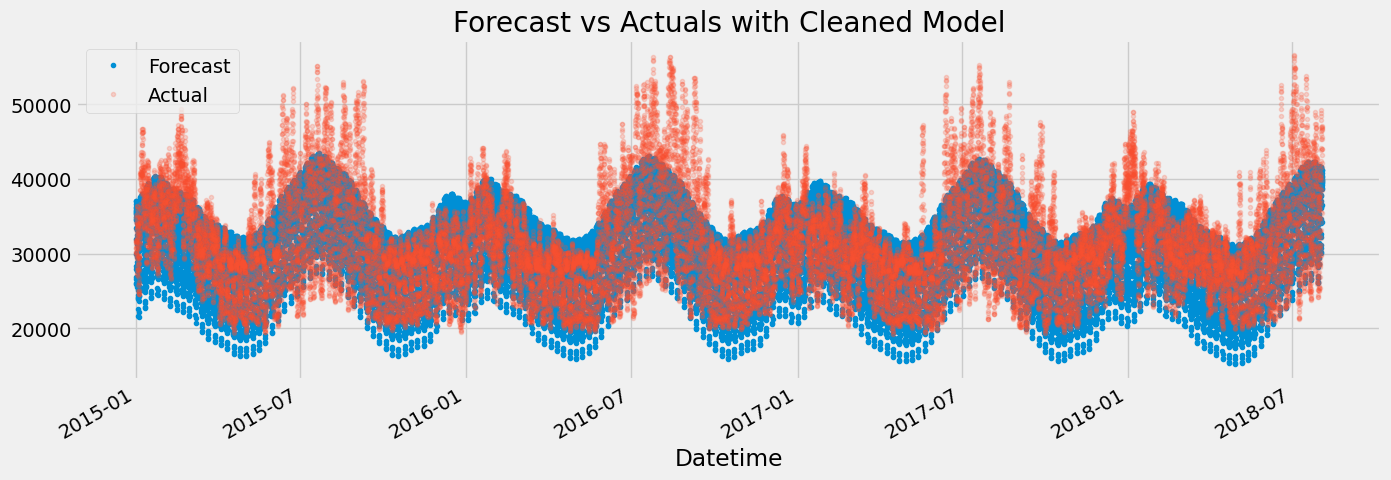

In [ ]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()